In [2]:
%matplotlib inline
import os.path as op
from pbcore.io import *
from PRmm.io import *
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from scipy import stats, integrate
import seaborn as sns
sns.set(color_codes=True)


RUNPATH = "/mnt/LIMS/vol73/3100046/0001/"
REPORTSFOLDER = "Alpha_DetThr-7p0"

alnFname = "/home/UNIXHOME/dalexander/Projects/git/VariantCallingReports/2015/HQ-Region-Finding/2C2A/UnrolledAll4mers/aligned_reads.cmp.h5"
basFname = op.join(RUNPATH, REPORTSFOLDER, "mAlpha-1-W_150819_101616.bas.h5")
plsFname = op.join(RUNPATH, REPORTSFOLDER, "mAlpha-1-W_150819_101616.pls.h5")
trcFname = op.join(RUNPATH, "mAlpha-1-W_150819_101616.trc.h5")

In [76]:
alnF = CmpH5Reader(alnFname)
trcF = TrxH5Reader(trcFname)
basF = BasH5Reader(basFname)
plsF = PlxH5Reader(plsFname)

In [4]:
alnF.HoleNumber

array([21496088, 13762856, 13828410, ..., 28770646, 28770662, 28770670], dtype=uint32)

In [6]:
trcF.holeNumbers

array([13238304, 13238305, 13238306, ..., 32047645, 32047646, 32047647], dtype=uint32)

In [7]:
# Find some ZMWs of interest (have sequence and even alignments!)
goodZmws = sorted(set.intersection(set(trcF.holeNumbers), set(alnF.HoleNumber)))



In [21]:
rls = [aln.readLength for aln in alnF] 
accs = [aln.identity for aln in alnF] 

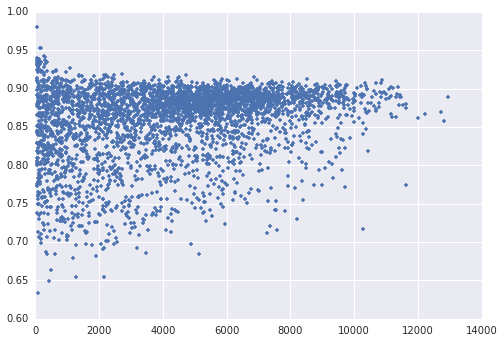

In [23]:
plt.plot(rls, accs, ".");

In [27]:
# WIP here

# Some capabilites to get info about aln by frames
from bisect import bisect_left, bisect_right

def alnsByHoleNumber(alnF, holeNumber):
    return alnF[alnF.HoleNumber == holeNumber]

def baseIntervalByFrameInterval(zmw, beginFrame, endFrame):
    read = zmw.readNoQC()
    baseEndFrame = np.cumsum(read.PreBaseFrames() + read.WidthInFrames())
    baseStartFrame = baseEndFrame - read.WidthInFrames()
    # beginBase: first base at least partly in the frame interval,
    #           so first base whose end is after the specificed beginFrame
    # endBase: last base at least partly in the frame interval,
    #          so last base whose start is before the specified endFrame
    beginBase = bisect_left(baseEndFrame, beginFrame)
    endBase   = bisect_right(baseStartFrame, endFrame)
    return (beginBase, endBase)

def alnsByBaseInterval(alnF, zmw, beginBase, endBase):
    pass
    
def alnsByHoleNumberAndTimeWindow(alnF, basF, holeNumber, frameSpan):
    pass



    



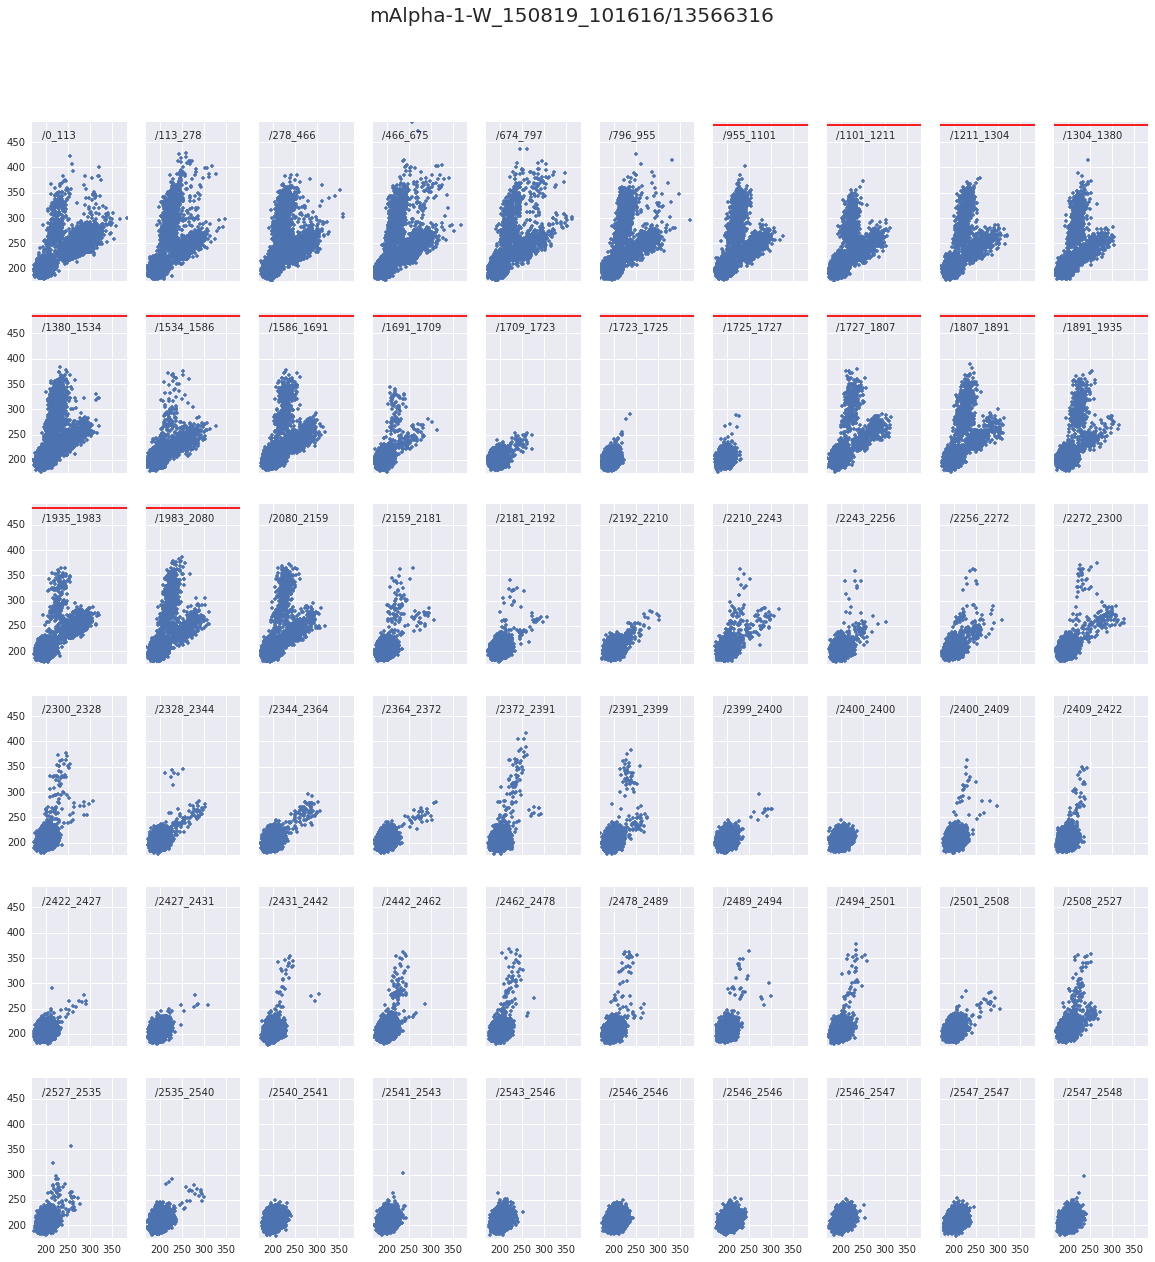

In [73]:
def plot2C2AScatterOverTime(holeNumber, basF, trcF, alnF):

    frameRate = 100  # TODO: provide accessor
    intervalFrames = 2*60 * frameRate
    
    zmw = basF[holeNumber]
    t = trcF[holeNumber]
    df = pd.DataFrame(np.transpose(t), columns=["C1", "C2"])
    
    aln = alnsByHoleNumber(alnF, holeNumber)[0]
    alnBaseInterval = (aln.rStart, aln.rEnd)
    
    matplotlib.rcParams['figure.figsize'] = np.array([10, 10])*2

    fig, ax = plt.subplots(6, 10, sharex=True, sharey=True, )
    fig.suptitle(trcF.movieName + "/" + str(holeNumber), fontsize=20)
    axr = ax.ravel()

    # what is the extent of the data?
    xmin, ymin = df.min()
    xmax, ymax = df.max()
    
    def fracX(frac): return xmin + (xmax - xmin) * frac
    def fracY(frac): return ymin + (ymax - ymin) * frac
        

    # 60 plots, 1 per minute
    for i in xrange(60):
        interval = slice(i*intervalFrames, (i+1)*intervalFrames)
    #   #sns.kdeplot(df.C1[interval], df.C2[interval])
        axr[i].set_xlim(xmin, xmax)
        axr[i].set_ylim(ymin, ymax)
        axr[i].plot(df.C1[interval], df.C2[interval], ".")

        baseInterval = baseIntervalByFrameInterval(zmw, interval.start, interval.stop)
        axr[i].text(fracX(0.1), fracY(0.9), "/%d_%d" %  (baseInterval[0], baseInterval[1]))
        
        # wholly within the aligned interval??
        if (baseInterval[0] >= alnBaseInterval[0]) and (baseInterval[1] < alnBaseInterval[1]):
            axr[i].hlines(fracY(0.98), xmin, xmax, colors=["red"])
            
        

plot2C2AScatterOverTime(goodZmws[1], basF, trcF, alnF)
        
# TODO: add "{X} bases aligned @ 75% acc"

In [80]:
# Let's approximate the fraction of occupancy of the baseline state.  Assuming only knowledge of baseline, 
# baselineSigma, assume a frame is baseline if it is within baseline + 2 sigma both channels.
# Questions:  
#   1) is there measured covariance b/w channels?  If so we should refine our approach
#   2) what is the prospective accuracy of this method?

t

plsZmw = plsF[goodZmws[1]]


print plsZmw.baseline()
print plsZmw.baselineSigma()






[ 381.72738647  381.72738647  315.86297607  315.86297607]
[ 10.38094997  10.38094997   9.35600948   9.35600948]


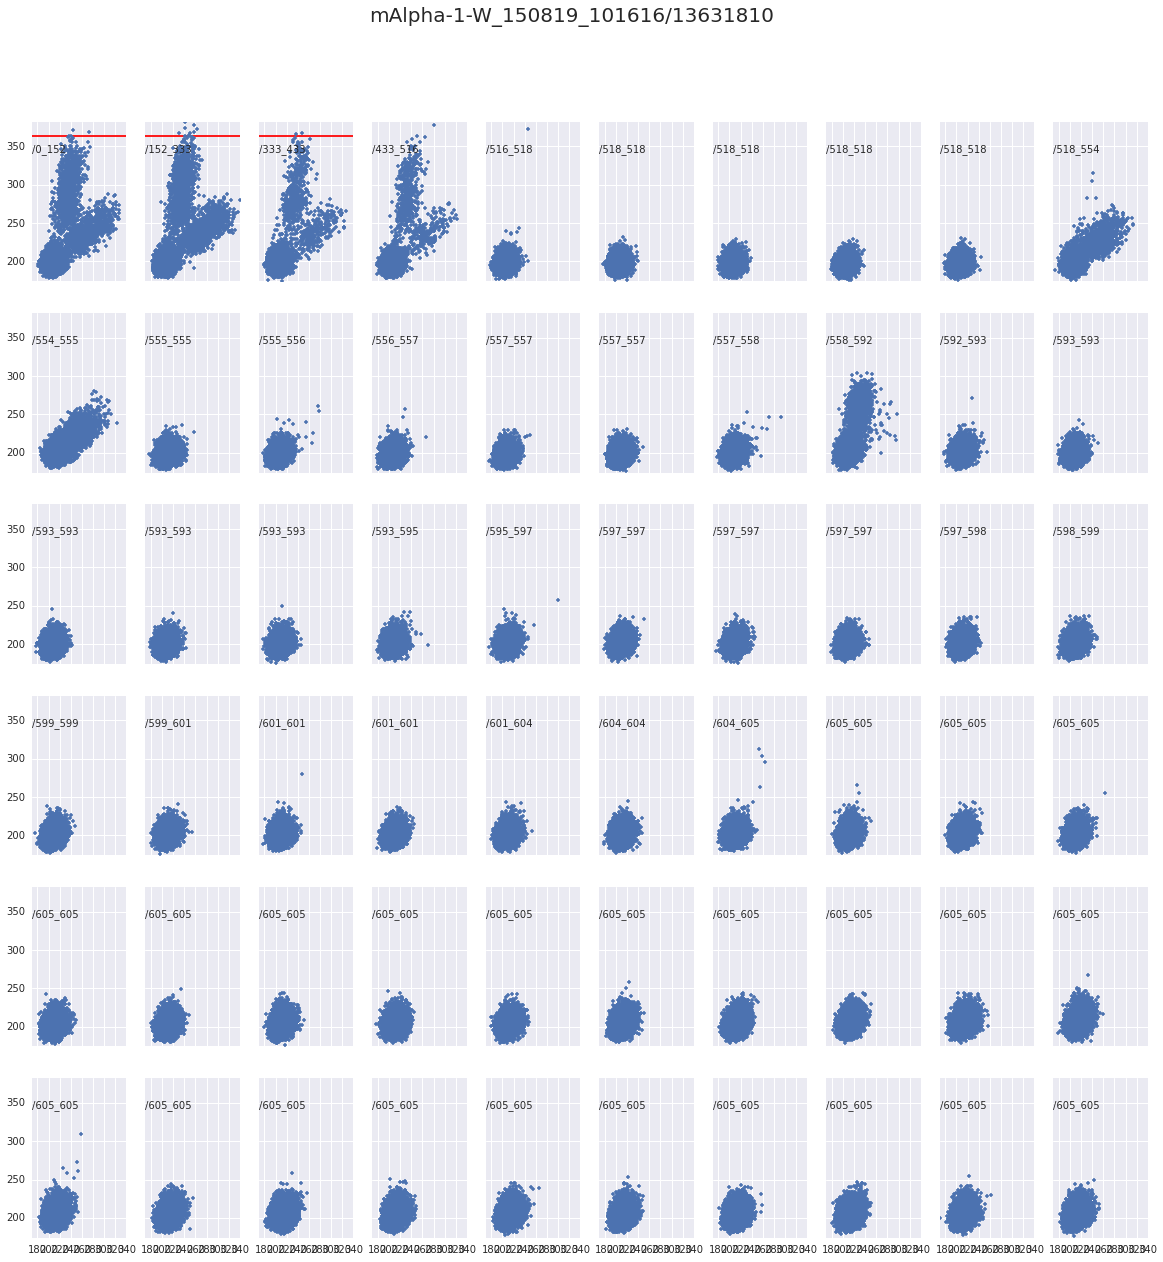

In [43]:
plot2C2AScatterOverTime(goodZmws[2], basF, trcF, alnF)

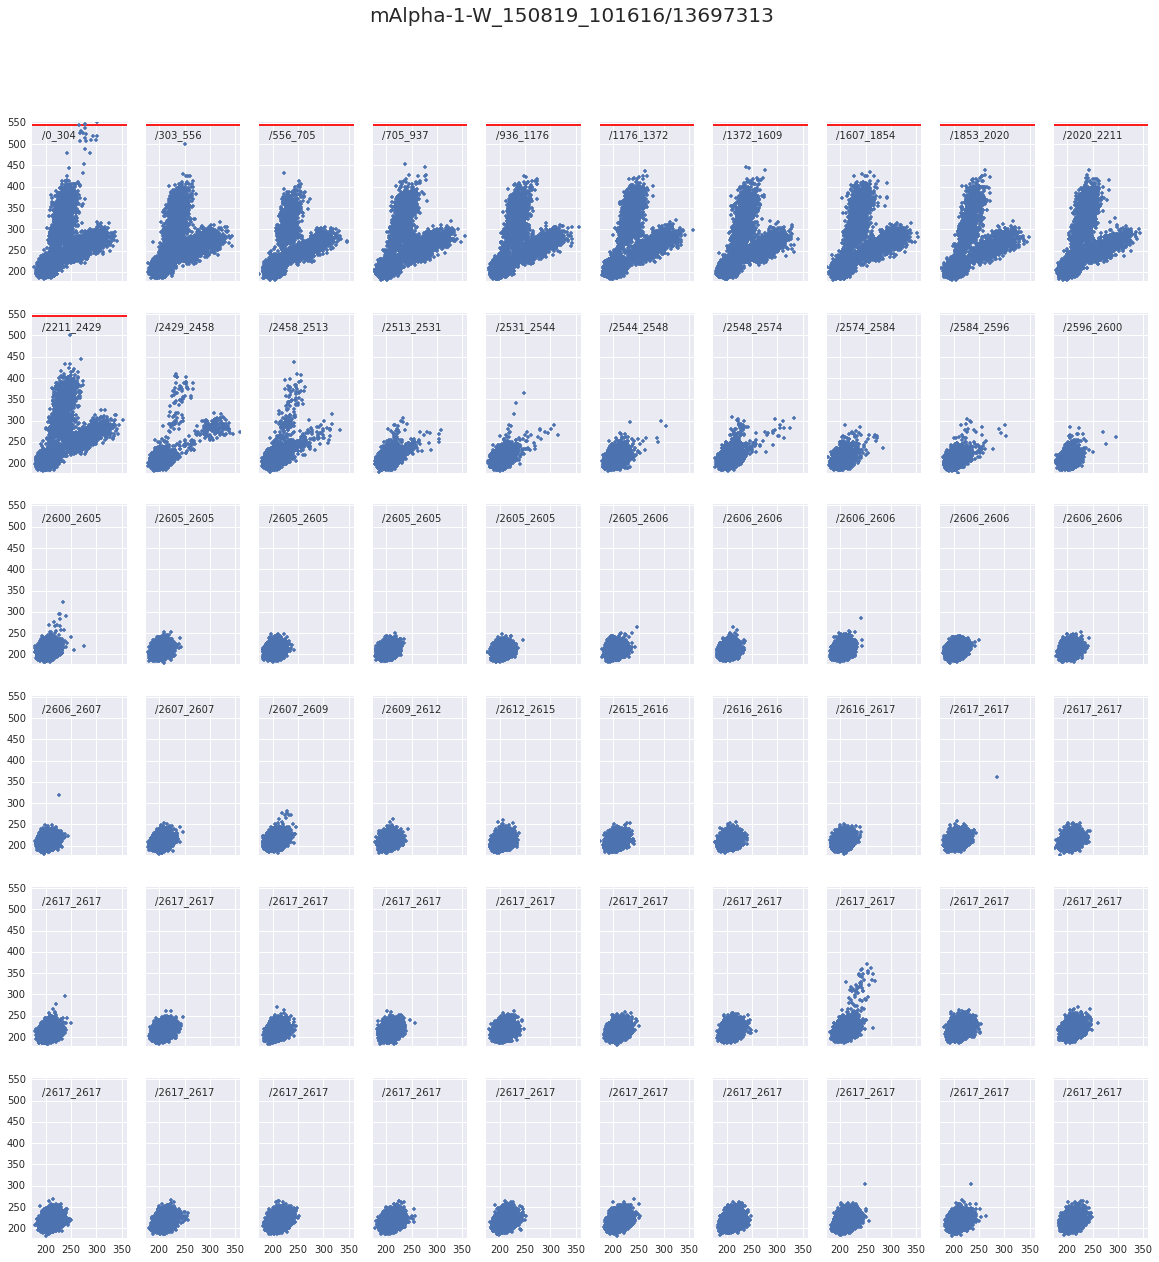

In [72]:
plot2C2AScatterOverTime(goodZmws[4], basF, trcF, alnF)

In [65]:
for i in range(100):
    hn = goodZmws[i]
    aln = alnsByHoleNumber(alnF, hn)[0]
    print i, hn, aln.rStart, aln.rEnd



 0 13566282 1597 1860
1 13566316 913 2124
2 13631810 0 503
3 13631874 0 986
4 13697313 0 2438
5 13697347 0 482
6 13697380 0 378
7 13762856 0 1204
8 13762860 0 2238
9 13762873 0 565
10 13762888 0 2914
11 13762909 0 210
12 13828370 8 1022
13 13828392 0 681
14 13828404 8 1039
15 13828410 3 1912
16 13828412 7 2201
17 13828422 3 732
18 13828424 3 321
19 13828428 7 5570
20 13828436 11 1880
21 13828444 2398 2924
22 13828458 7 73
23 13828463 30 727
24 13828483 14 876
25 13893906 0 729
26 13893922 0 841
27 13893935 0 969
28 13893951 0 1501
29 13893986 0 1141
30 13893988 275 1108
31 13893989 5 3450
32 13894023 6267 7012
33 13959448 0 837
34 13959456 0 238
35 13959470 0 1570
36 13959481 0 654
37 13959484 0 750
38 13959485 0 2112
39 13959504 0 2397
40 13959509 21 92
41 13959515 8 639
42 13959530 0 1832
43 13959544 59 1767
44 13959553 22 626
45 13959558 0 1525
46 14024974 7 2102
47 14024975 1 1267
48 14024978 181 340
49 14024983 2 1636
50 14024989 0 731
51 14024991 7 1061
52 14024996 4 2330
53 1402

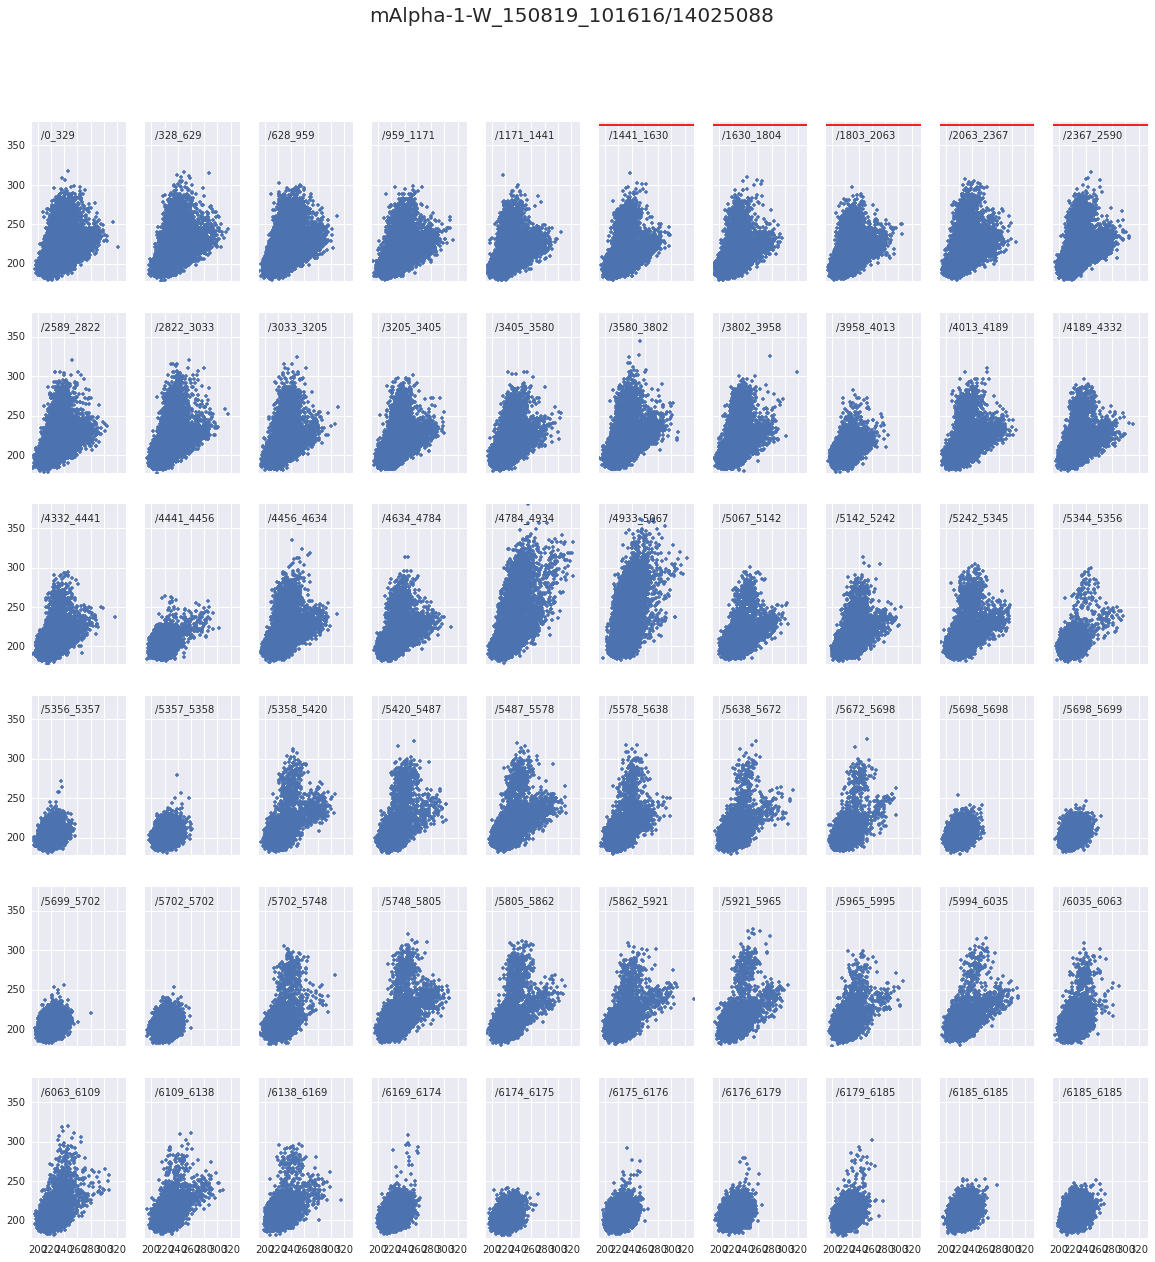

In [66]:
plot2C2AScatterOverTime(goodZmws[61], basF, trcF, alnF)

In [71]:
print alnsByHoleNumber(alnF, goodZmws[61])[0]
basF[goodZmws[61]].hqRegionSnr

CmpH5 alignment: +    8        262       1706

Read:        mAlpha-1-W_150819_101616/14025088/1177_2631
Reference:   All4mer.V2.37_circular_72x_l50256

Read length: 1454
Concordance: 0.736

  23456789012345678901234567890123456789901234567890123456789012345678901234567890
  ACTACCGACTGTTTCAAGCTTGCTGAGGACTAGTAGC-TTCTCTCTCTCAACAACAACAACGGAGGAGGAGGAAAAGAGA
  |||||||||||||||*||||||||  ||||||*|| | ||||||||||| |||||||| || ||*||||*||  *| |||
  ACTACCGACTGTTTCCAGCTTGCT--GGACTATTA-CTTTCTCTCTCTC-ACAACAAC-AC-GATGAGGCGG--CA-AGA


  12345678901234456789012345678901234567889012345678901112344567890123345678901234
  GAGAGAAGCTACT-AGTCCTCAGCAAGCTTGAAACAGT-CGGTAGTTACCTT--TGC-GATTGAGCA-GCCCAACGAGAA
  ||||| |*|| || ||| |||||||||||| *||| || ||||||||| |||  *|| |||**||*| |||| || || |
  GAGAG-ATCT-CTCAGT-CTCAGCAAGCTT-TAAC-GTACGGTAGTTA-CTTGCGGCTGATCAAGAAGGCCC-AC-AG-A


  56789012345678901223445678900123456789012234567890123456789011234567890123445678
  AGAGGTCCAGGGGAGTA-CA-ATCGTG-GTTTATATGCTA-TCTTCACATAGCTTGT

array([ 7.19150639,  3.92000318,  7.95877647,  4.02505064], dtype=float32)